In [1]:
import warnings

warnings.filterwarnings(action="ignore", message="The RandomType SharedVariables")

import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, MonthLocator, YearLocator, DateFormatter

import pymc_experimental.statespace as pmss
import pymc as pm
from pymc.model.transform.optimization import freeze_dims_and_data

import preliz as pz
import pandas as pd
import arviz as az
import yfinance as yf
import numpy as np
import nutpie as ntp
import os

plt.rcParams.update(
    {
        "figure.figsize": (14, 4),
        "figure.dpi": 144,
        "figure.facecolor": "w",
        "axes.grid": True,
        "grid.linewidth": 0.5,
        "grid.linestyle": "--",
        "axes.spines.top": False,
        "axes.spines.bottom": False,
        "axes.spines.left": False,
        "axes.spines.right": False,
    }
)

In [2]:
import ipywidgets as widgets
from IPython.display import display
from functools import partial
import pytensor
import pytensor.tensor as pt
from pymc_experimental.statespace.filters.distributions import LinearGaussianStateSpace


def make_update_plot(
    close_data,
    f_ets,
    f_forecast,
    n_draws=100,
    include_trend=False,
    include_phi=False,
    draw_lines=True,
):
    def update_plot(**kwargs):
        initial_state_cov = np.eye(2 + int(include_trend))

        if include_trend and not include_phi:
            kwargs["phi"] = 1.0

        mu, cov = f_ets(**kwargs, initial_state_cov=initial_state_cov)

        x_vals = close_data.index
        x_forecast = close_data.index.shift(30)[-30:]

        fig, ax = plt.subplots(figsize=(14, 4), dpi=144)

        ax.plot(x_vals, mu[:, 1], label="Prediction")
        ax.plot(x_vals, close_data.values, label="Data", ls="--", c="k")

        ax.fill_between(
            x_vals,
            mu[:, 1] - 1.96 * np.sqrt(cov[:, 1, 1]),
            mu[:, 1] + 1.96 * np.sqrt(cov[:, 1, 1]),
            alpha=0.25,
            label="In-Sample 94%",
        )

        f = partial(f_forecast, **kwargs, initial_state_cov=initial_state_cov)

        forecast_draws = np.r_[[f().ravel() for _ in range(n_draws)]]
        mu_forecast = forecast_draws.mean(axis=0)
        cov_forecast = forecast_draws.var(axis=0)

        ax.plot(x_forecast, mu_forecast[1:], label="Forecast")
        ax.fill_between(
            x_forecast,
            mu_forecast[1:] - 1.96 * np.sqrt(cov_forecast[:-1]),
            mu_forecast[1:] + 1.96 * np.sqrt(cov_forecast[:-1]),
            alpha=0.25,
            color="tab:orange",
            label="Forecast 94%",
        )

        if draw_lines:
            ax.axhline(close_data.values[-1], ls="--", c="tab:green", label="Random Walk Forecast")
            ax.axhline(close_data.mean().item(), ls="--", c="tab:red", label="Mean Forecast")

        ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
        plt.show()

    return update_plot


def mod_to_functions(mod, df):
    # Extract kalman filter outputs -- these are the iterative in-sample estimates
    filter_outputs = mod.kalman_filter.build_graph(
        pt.as_tensor_variable(df_train.Close.values[:, None]),
        *mod._unpack_statespace_with_placeholders(),
        mode="JAX",
    )
    (
        filtered_states,
        predicted_states,
        observed_states,
        filtered_covariances,
        predicted_covariances,
        observed_covariances,
        loglike_obs,
    ) = filter_outputs

    # Save the last in-sample state and covariance. These are the initial states for forecasting.
    x0, Sigma0 = filtered_states[-1], filtered_covariances[-1]

    # Create a 30-day ahead forecast distribution by iterating on the statespace, starting from the x0 and Sigma0
    _, obs_forecast = LinearGaussianStateSpace.dist(
        x0, Sigma0, *mod._unpack_statespace_with_placeholders()[2:], mode="JAX", steps=30
    )

    # Make a function that returns in-sample mean and cov
    f_ets = pytensor.function(
        pm.inputvars(predicted_states), [predicted_states, predicted_covariances], mode="JAX"
    )

    # For the forecasts we need a function that lets us take draws from the distribution. We'll get the mean
    # and covariance from samples by calling it a lot of times.
    f_forecast = pm.compile_pymc(pm.inputvars(obs_forecast), obs_forecast, mode="JAX")

    return f_ets, f_forecast


def make_interactive_plot(
    mod, df_train, df_test, include_trend=False, include_phi=False, draw_lines=True, n_draws=100
):
    f_ets, f_forecast = mod_to_functions(mod, df_train)

    update_plot = make_update_plot(
        close_data=df_train.Close,
        f_ets=f_ets,
        f_forecast=f_forecast,
        n_draws=n_draws,
        include_trend=include_trend,
        include_phi=include_phi,
        draw_lines=draw_lines,
    )

    alpha_slider = widgets.FloatSlider(
        value=0.99, min=1e-6, max=1 - 1e-6, step=0.01, description="Alpha:"
    )
    beta_slider = widgets.FloatSlider(
        value=0.0, min=1e-6, max=1 - 1e-6, step=0.01, description="Beta:"
    )
    phi_slider = widgets.FloatSlider(value=1.0, min=0.8, max=1, step=0.01, description="Phi:")

    sigma_slider = widgets.FloatSlider(
        value=1.0, min=0.1, max=10.0, step=0.1, description="Sigma State:"
    )

    initial_level_slider = widgets.FloatSlider(
        value=df_train.Close.values[0], min=0, max=100.0, step=0.1, description="Initial Level:"
    )
    initial_trend_slider = widgets.FloatSlider(
        value=0, min=-10, max=10, step=0.1, description="Initial Trend:"
    )

    kwargs = {
        "alpha": alpha_slider,
        "sigma_state": sigma_slider,
        "initial_level": initial_level_slider,
    }

    if include_trend:
        kwargs["beta"] = beta_slider
        kwargs["initial_trend"] = initial_trend_slider

    if include_phi:
        kwargs["phi"] = phi_slider

    preferred_order = ["alpha", "beta", "phi", "initial_level", "initial_trend", "sigma_state"]
    kwargs = {key: kwargs[key] for key in preferred_order if key in kwargs}

    return widgets.interactive(update_plot, **kwargs)

In [3]:
def plot_candlesticks(df, lw=0.5):
    delta = pd.Timedelta(hours=18)
    half_delta = pd.Timedelta(hours=9)

    gs = plt.GridSpec(nrows=4, ncols=1)
    fig = plt.figure()
    candlestick_ax = fig.add_subplot(gs[:-1, :])
    volume_ax = fig.add_subplot(gs[-1, :])

    # Draw the body
    candlestick_ax.hlines(df.Open, df.index - delta, df.index, lw=lw, color="k")
    candlestick_ax.hlines(df.Close, df.index - delta, df.index, lw=lw, color="k")
    candlestick_ax.vlines(df.index, df.Open, df.Close, lw=lw, color="k")
    candlestick_ax.vlines(df.index - delta, df.Open, df.Close, lw=lw, color="k")

    # Color

    color = (df.Close - df.Open).map(lambda x: "tab:red" if x < 0 else "tab:green")
    for c in ["tab:red", "tab:green"]:
        color_mask = color == c
        augmented_dates = np.column_stack(
            (
                df.index.values[color_mask],
                df.index.values[color_mask] - delta,
                np.full(color_mask.sum(), np.nan, dtype=np.datetime64),
            )
        )
        candlestick_ax.fill_between(
            augmented_dates.ravel(),
            df.Open.values[color_mask].repeat(3),
            df.Close.values[color_mask].repeat(3),
            color=c,
            alpha=0.5,
        )

    # Draw the wick
    max_open_close = df[["Open", "Close"]].max(axis=1)
    min_open_close = df[["Open", "Close"]].min(axis=1)

    candlestick_ax.hlines(df.High, df.index - delta, df.index, lw=lw, color="k")
    candlestick_ax.hlines(df.Low, df.index - delta, df.index, lw=lw, color="k")
    candlestick_ax.vlines(df.index - half_delta, max_open_close, df.High, lw=lw, color="k")
    candlestick_ax.vlines(df.index - half_delta, min_open_close, df.Low, lw=lw, color="k")
    candlestick_ax.set(xticklabels=[], ylabel="Price")

    volume_ax.bar(df.index, df.Volume, color=color, alpha=0.5)
    volume_ax.bar(df.index, df.Volume, edgecolor="k", facecolor="none", lw=1)

    volume_ax.xaxis.set_major_locator(MonthLocator(interval=1))
    volume_ax.xaxis.set_minor_locator(DayLocator(interval=7))
    volume_ax.xaxis.set_major_formatter(DateFormatter("%b"))

    years = YearLocator()
    years_fmt = DateFormatter("%Y")
    xmin, xmax = volume_ax.get_xlim()

    for year in years.tick_values(df.index.min(), df.index.max()):
        volume_ax.text(
            max(year, xmin),
            -0.6,
            years_fmt(year),
            transform=volume_ax.get_xaxis_transform(),
            ha="center",
            fontsize=9,
        )

    volume_ax.set(ylabel="Volume")

    return fig

# Exponential Trend Smoothing

Exponential Trend Smoothing (ETS) models are a powerful family of timeseries models purpose build for forecasting. Early researchers working, including [Brown (1959)](#Brown1959), [Holt (1957)](#Holt1957), and [Winters (1960)](#Winters1960) on these models were concered first and foremost with forcasting. [Forcasting, Principals and Practice, Chapter 8](https://otexts.com/fpp3/expsmooth.html) should be regarded as the first and last word on these methods. This presentation will draw heavily on this chapter, and it should be consulted for a deeper understanding of the ETS method.

ETS begins from a simple proposition: the future should look like the past. This is a common enough proposition in time series modeling -- all models end up using past observations as "features" in the models. The question is "which past should be used?".

To think through this question, we'll use some stock price data. Stock prices are notoriously hard to forecast, so it will be a nice testbed. Let's look at the hottest tech stock at the time of writing, Nvidia ($NVDA), manufacturer of GPUs used to train large language models (and, more importantly, to do ray-tracing in Minecraft mods).


In [4]:
import datetime

FORCE_UPDATE = False

if not os.path.isdir("data"):
    os.mkdir("data")

if not os.path.exists("data/nvda-1yr.csv") or FORCE_UPDATE:
    today = pd.Timestamp(datetime.datetime.today())
    year_delta = pd.Timedelta(days=365)

    nvda = yf.Ticker("NVDA").history(start=today - year_delta, end=today)
    nvda.to_csv("data/nvda-1yr.csv")
else:
    nvda = pd.read_csv("data/nvda-1yr.csv")
    nvda.Date = pd.to_datetime(nvda.Date, utc=True).dt.tz_localize(None)
    nvda = nvda.set_index("Date")

In [5]:
train_pct = 0.7
test_pct = 0.2
dev_pct = 0.1

assert np.allclose(train_pct + test_pct + dev_pct, 1.0)
T = nvda.shape[0]
range_idx = np.arange(T)
cutpoints = np.quantile(range_idx, np.cumsum([train_pct, test_pct, dev_pct])).astype(int)

train_end_date = nvda.index[cutpoints[0]]
test_end_date = nvda.index[cutpoints[1]]

df_train = nvda.loc[:train_end_date]
df_test = nvda.loc[train_end_date:test_end_date]
df_dev = nvda.loc[test_end_date:]


# Resample to business days, just so we can have a frequency on the index
# This will introduce missing values on days when the market is closed, but that's ok
df_train = df_train.resample("B").first()
df_train.index.freq = df_train.index.inferred_freq

Nvidia has been enjoying a crazy bull run for the last couple years. At the time of writing (Aug 10, 2024), though, there's been a huge pullback in technology stocks over the past few weeks. This notebook will hopefully end up as something of a cautionary tale about predicting stock prices: don't try!

Here is the candlestick plot for NVDA between August 2023 and June 2024. These are a favorite of so-called "technical analysts", who use them to look for patterns, which they then use to trade on and lose money (in expectation). Can you spot the head and shoulders formation? Me either. They are quite pretty though, and summarize a lot of information in an easy-to-read way.

Each "candlestick" is a day of trading activity. The size of the candlestick (the colored rectangle) is the size of the day's opening price minus the closing price. If it's red, the stock closed lower than it opened (went down over the day). Green means it went up over the day.

The "wick" show the day's high and low price -- the maximum price that was attained that day. 

At the bottom is the daily training volume: the number of transations between buyers and sellers that took place voer the course of the day. For a big popular stock like Nvidia, this is a big number: notice that the y-axis scale is in billions!

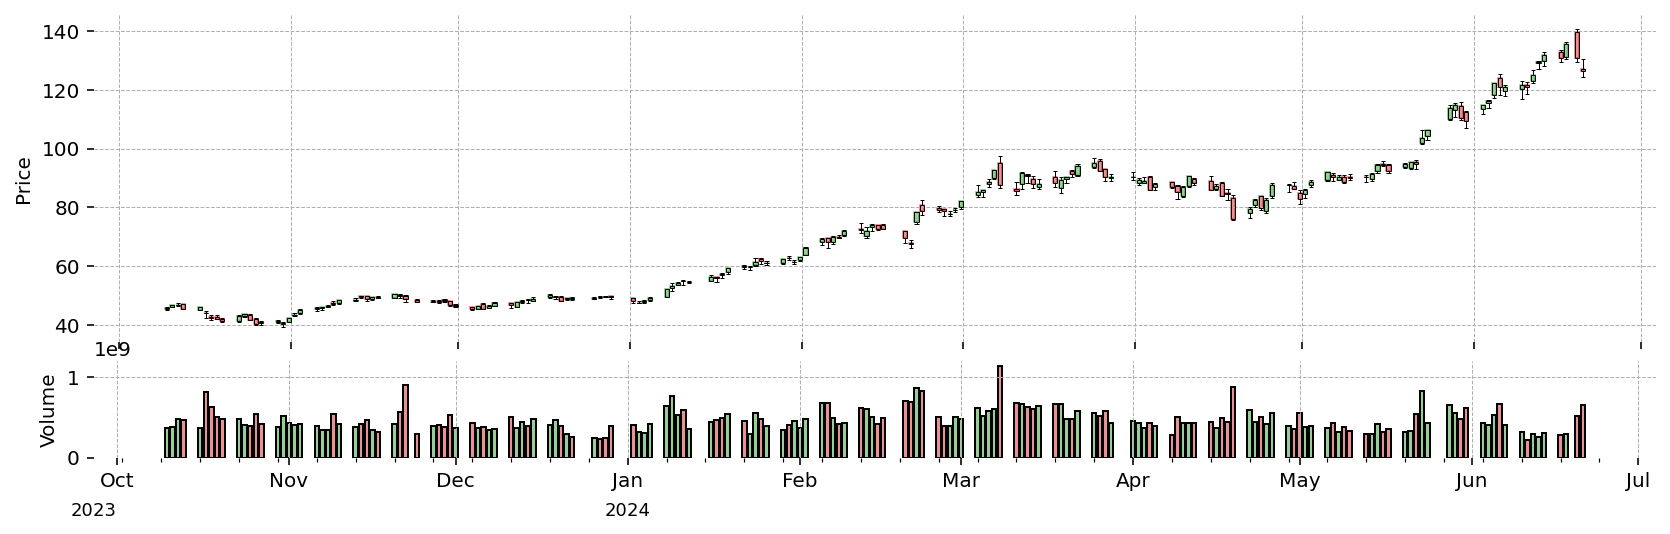

In [6]:
plot_candlesticks(df_train);

Zooming in on the last 50 days makes the candlesticks a bit easier to see:

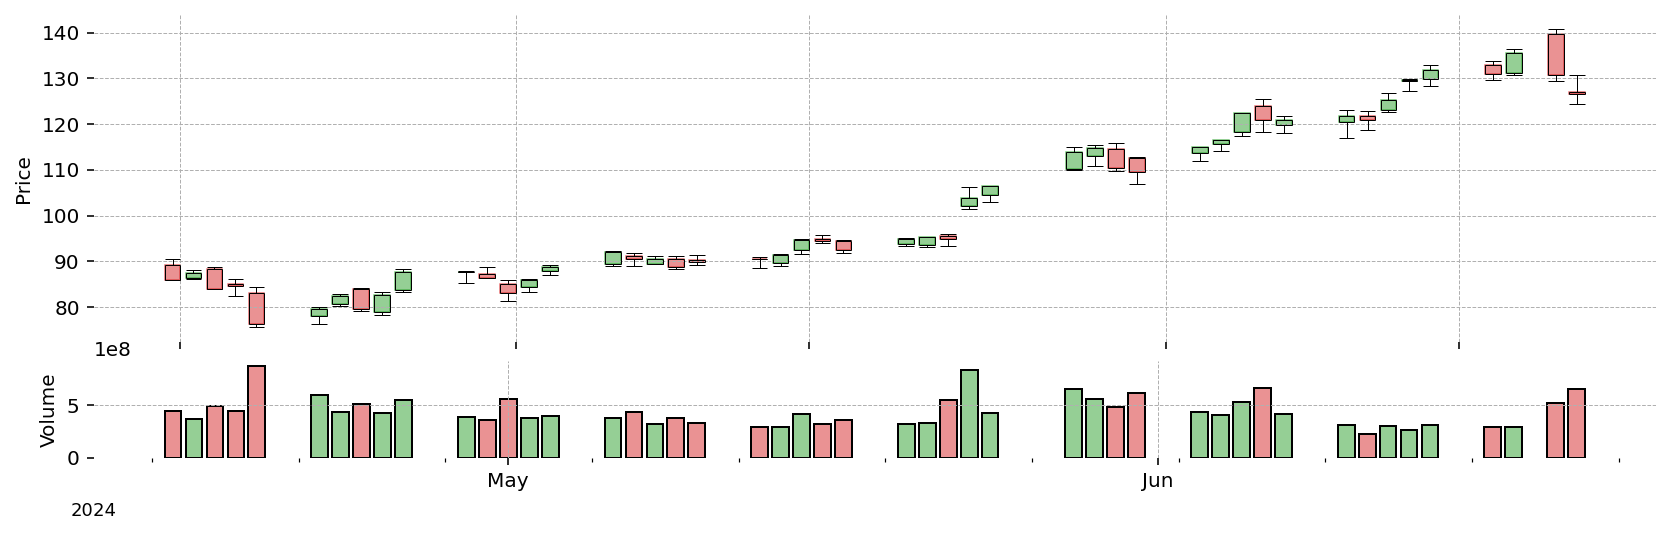

In [7]:
plot_candlesticks(df_train.tail(50));

Anyway, forcasting. We will use the past to predict the future. One idea might be that the future will look just like today. This isn't so crazy, it's the so-called "random walk" assumption. The implied statistical model is:

$$
\begin{align}
P_t &= P_{t-1} + \varepsilon_t \\
\varepsilon_t &\sim N(0, \sigma)
\end{align}
$$

Prices today are the same as prices yesterday (in expectation). This seems pretty bad assumption, as there appears to be a trend. Nevertheless, stock prices (actually log prices, but I elide this detail here) are believed to follow a gaussian random walk. So it should forecast well enough!

In [8]:
def plot_candlesticks_with_forecast(
    df_train, df_test, idata=None, idata_forecast=None, draw_rw=False, draw_mean=False
):
    forecast_idx = pd.date_range(start=df_train.index[-1], end=df_test.index[-1], freq="B")

    H = forecast_idx.shape[0]

    rw_forecast = pd.DataFrame(np.full(H, df_train.Close.values[-1]), index=forecast_idx)
    mean_forecast = pd.DataFrame(np.full(H, df_train.Close.mean()), index=forecast_idx)
    fig = plot_candlesticks(df_train)
    price_ax, vol_ax = fig.axes

    if draw_rw:
        price_ax.plot(rw_forecast.index, rw_forecast.values, ls="--", label="Random Walk Forecast")
    if draw_mean:
        price_ax.plot(rw_forecast.index, mean_forecast.values, ls="--", label="Mean Forecast")

    draw_in_sample = idata is not None
    draw_forecasts = idata_forecast is not None

    if draw_in_sample:
        post_dist = idata.predicted_posterior_observed.isel(observed_state=0)

        mu = post_dist.mean(dim=["chain", "draw"])
        hdi = az.hdi(post_dist).predicted_posterior_observed

        price_ax.plot(df_train.index, mu.values, label="In-Sample Mean")
        price_ax.fill_between(
            df_train.index, *hdi.values.T, alpha=0.25, color="tab:blue", label="In-Sample 94% HDI"
        )

    if draw_forecasts:
        forecast_dist = idata_forecast.forecast_observed.isel(observed_state=0, time=slice(1, None))
        mu_forecast = forecast_dist.mean(dim=["chain", "draw"])
        hdi_forecast = az.hdi(forecast_dist).forecast_observed

        price_ax.plot(df_test.index, mu_forecast.values, label="Test Forecast")
        price_ax.fill_between(
            df_test.index,
            *hdi_forecast.values.T,
            alpha=0.25,
            color="tab:orange",
            label="Forecast 94% HDI",
        )

    price_ax.plot(df_test.index, df_test.Close.values, color="tab:purple", label="Test Close")
    ncol = min(
        4, 1 + int(draw_rw) + int(draw_mean) + int(draw_in_sample) * 2 + int(draw_forecasts) * 2
    )

    fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.01), ncol=ncol)
    vol_ax.bar(rw_forecast.index, np.full(H, 0))

    return fig

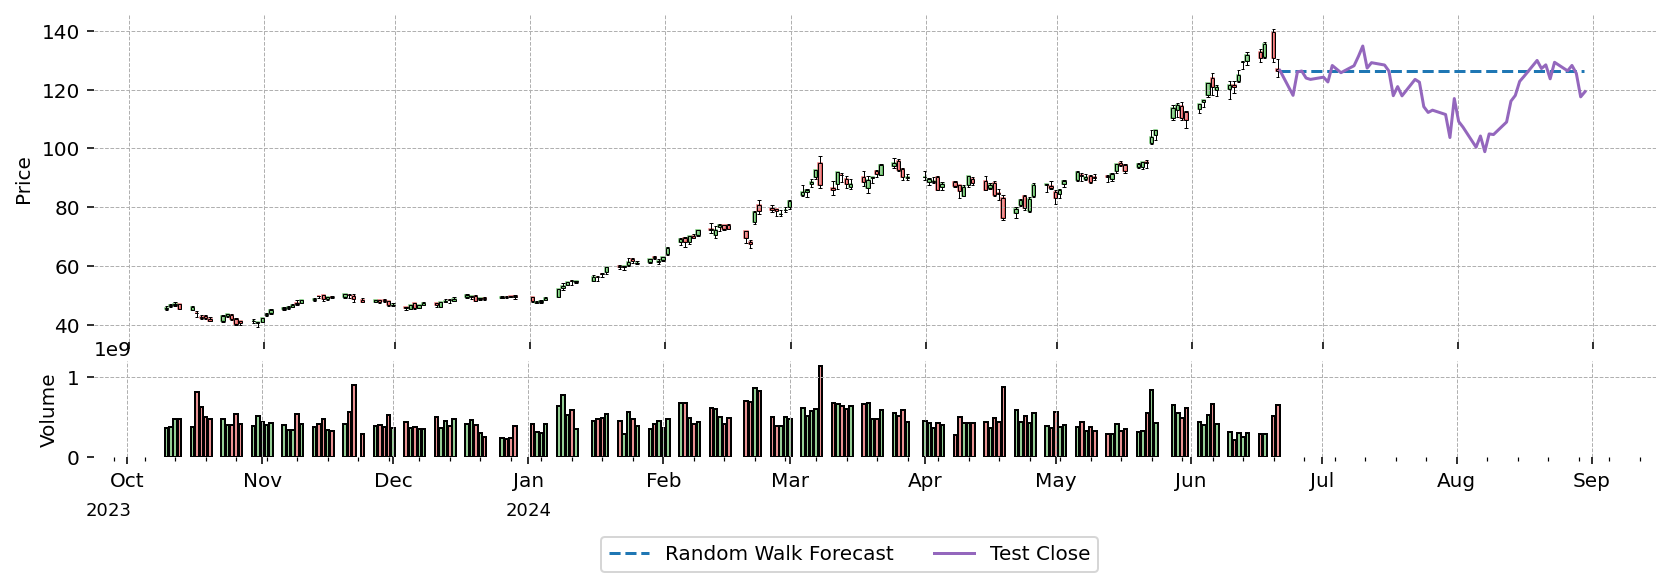

In [9]:
plot_candlesticks_with_forecast(df_train, df_test, draw_rw=True);

This is a pretty good illustraton of the strength of the random walk assumption, and of the frustrating difficulty of forecasting. Obviously if we had split the  train/test set differently, we would have ended up with something very different.  There have been large price movements since the end of training data, notably in July 2023, but the price appears to have come back to the current price.

Why the current price, though? The Efficient Market Hypothesis (EMH) argues that current prices reflect all available information, both public and private, present and past. Thus, the current price is the best you can do -- there's nothing more to learn about from past data.

If this strikes you as a bold claim, you're not alone. I will not blame you for wanting to try to wring out some information from the past. For example, instead of forecasting with the current price, we can forecast with the sample average price. This takes all available information into account, weighting it all equally:

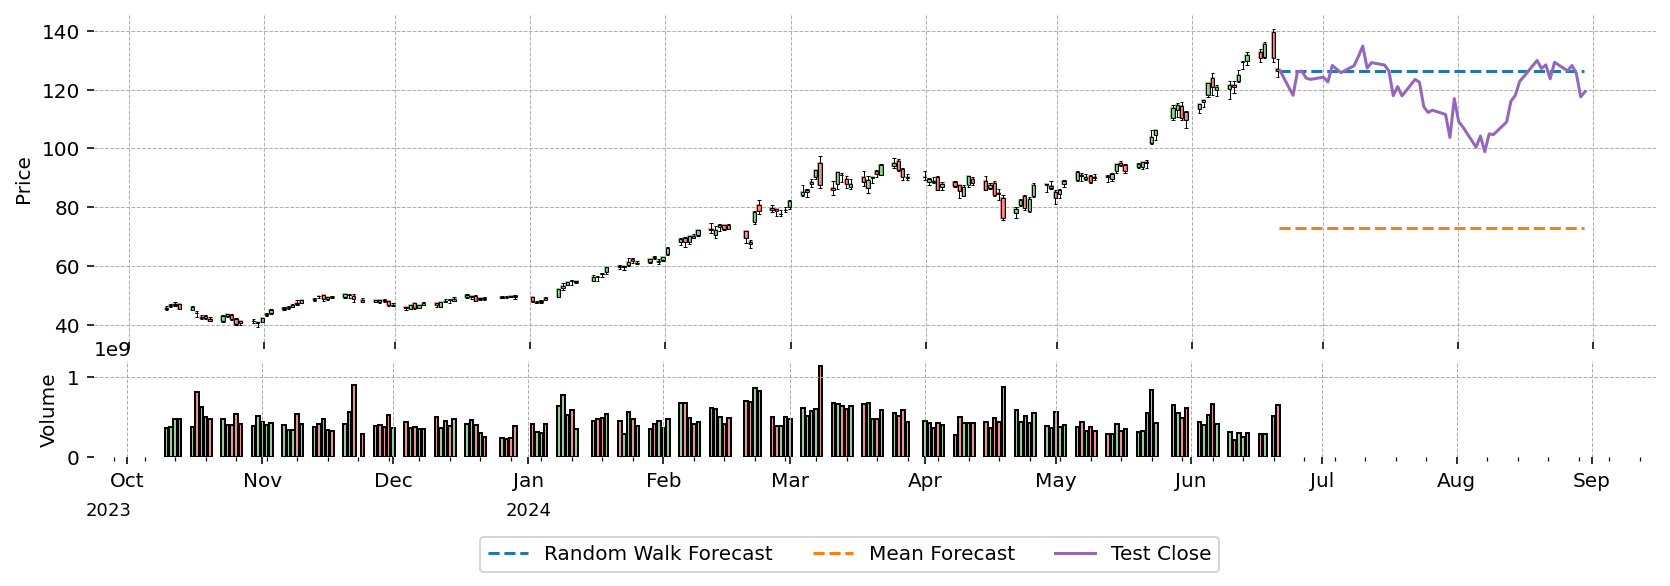

In [10]:
plot_candlesticks_with_forecast(df_train, df_test, draw_rw=True, draw_mean=True);

Why is the average forecast even worse? Intuitively, we might not expect price values from 12 months ago to matter. Data from before the January-March 2024 increase is pulling the average down. Do we really believe that this entire run-up in valuation will be reversed tomorrow? Probably not.

We can view both of these forecasts as weighted functions of the data. Specifically, they are both $P_{t+h} = \sum_{t=0}^T w_t P_t$, where $w = \begin{bmatrix}0 & 0 & \cdots & 0 & 1\end{bmatrix}$ in the random walk case, and $w = \begin{bmatrix} \frac{1}{T} & \frac{1}{T} & \cdots & \frac{1}{T} & \frac{1}{T}\end{bmatrix}$ in the mean case.

What would be better is a weighting scheme that weights recent data more heavily than past data. This is the ETS model. We will choose:

$$
w = \begin{bmatrix} \alpha (1 - \alpha)^{T} & \alpha (1 - \alpha)^{T-1} \cdots & \alpha (1 - \alpha)^2 & \alpha (1 - \alpha) & \alpha \end{bmatrix}
$$

With $\alpha \in (0, 1)$ as a smoothing parameter that tells us how quickly the importance of past data decays as we move through time. 

This next plot shows how varying alpha changes the importance of past datapoints in the forecast. When alpha is very small (blue, hiding at the bottom), we're quite close to the mean situation where all datapoints are given equal weight (homework: show that $\lim_{a \to 0} \sum_{t=0}^\infty a(1 - a)^t = 1$, implying uniform weights). When alpha is large, only the recent past matters. At $\alpha=1$, we are in the random walk regime.

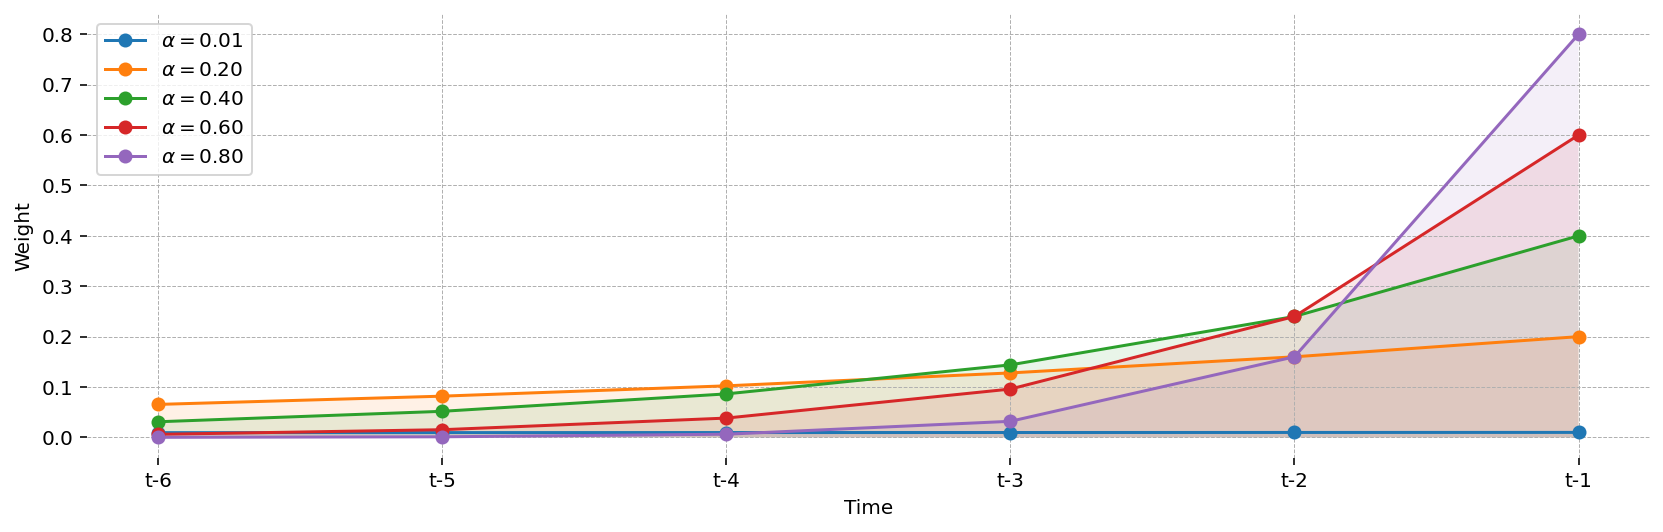

In [11]:
alphas = [0.01, 0.2, 0.4, 0.6, 0.8]
# time_grid = np.linspace(0, 5, 100)
time_grid = np.arange(0, 6)

fig, ax = plt.subplots()
for i, alpha in enumerate(alphas):
    #     ax.bar(powers[::-1] + 0.15 * i, w_df.iloc[:, i], width=0.15)
    decay = alpha * (1 - alpha) ** time_grid[::-1]
    ax.fill_between(time_grid, 0, decay, alpha=0.1)
    ax.plot(time_grid, decay, label=f"$\\alpha = {alpha:0.2f}$", marker="o")
ax.legend()
ax.set(
    ylabel="Weight",
    xlabel="Time",
    xticks=np.arange(6),
    xticklabels=[f"t-{h}" for h in range(6, 0, -1)],
)
plt.show()

For our purposes, it is important to note that the equation for the weights can be rewritten recursively. Suppose we start with an initial state (call it the "level" of the time series), $\ell_0$. We then observe $P_1$, and want to update our level value to $\ell_1$. This first update will be:

$$ \ell_1 = \alpha P_1 + (1 - \alpha) \ell_0$$

And so on:

$$
\begin{align}
\ell_2 &= \alpha P_2 + (1 - \alpha) \ell_1 \\
\ell_3 &= \alpha P_3 + (1 - \alpha) \ell_2 \\
\ell_4 &= \alpha P_4 + (1 - \alpha) \ell_3 \\
& \vdots \\
\ell_t &= \alpha P_t + (1 - \alpha) \ell_{t-1}
\end{align}
$$

Repeatedly forward substitute $\ell_2$ into $\ell_3$ and so on to obtain:

$$
\begin{align}
\ell_2 &= \alpha P_2 + (1 - \alpha) \alpha P_1 + (1 - \alpha) \ell_0 \\
\ell_3 &= \alpha P_3 + (1 - \alpha) (\alpha P_2 + (1 - \alpha) \alpha P_1 + (1 - \alpha) \ell_0) \\
&= \alpha P_3 + \alpha (1 - \alpha) P_2 + \alpha (1 - \alpha)^2 P_1 + (1 - \alpha) ^2 \ell_0 \\
\ell_4 &= \alpha P_4 + (1 - \alpha) (\alpha P_3 + \alpha (1 - \alpha) P_2 + \alpha (1 - \alpha)^2 P_1 + (1 - \alpha) ^2 \ell_0) \\
&= \alpha P_4 + \alpha (1 - \alpha) P_3 + \alpha (1 - \alpha)^2 P_2 + \alpha (1 - \alpha)^3 P_1 + (1 - \alpha)^3 \ell_0 \\
& \vdots \\
\ell_t &= \sum_{s=0}^t \alpha (1 - \alpha)^s P_{t-s} + (1 - \alpha)^t \ell_0
\end{align}
$$

This shows a nice recursive formulation we can use to estimate these models. The we keep track of a hidden state, the estimated level $\ell_t$, and we update it each step by taking a weighted average of the new observation $P_t$, and the previous hidden state, $\ell_{t-1}$. 

# Statespace Form

Recall that a linear-gaussian statespace is written as:

$$\begin{align}
x_t &= Ax_{t-1} + c_t + R\varepsilon_t \\
y_t &= Zx_t + d_t + \eta_t \\
\varepsilon_t &\sim N(0, Q) \\
\eta_t &\sim N(0, H)
\end{align}
$$

Taking $\ell_t$ as our $x_t$, we're starting to get quite close to this formulaion:

$$
\ell_t = \alpha P_t + (1 - \alpha) \ell_{t-1}
$$

We'd really like to do two things at this stage. First, eliminate $P_t$ from the transition equation, because this should not depend on the observed data, and certainly not on data that is contemporaneous with our hidden states (otherwise what is the use of forecasting!). Second, we'd like some source of stochastic innovations to drive the system.

We can accomplish both of these at once by thinking about the _estimation error_, $P_t - \ell_t$. Do some algebra:

$$
\begin{align}
\ell_t &= \alpha P_t + (1 - \alpha) \ell_{t-1} \\
& = \alpha P_t + \ell_{t-1} - \alpha \ell_{t-1} \\
& = \ell_{t-1} + \alpha (P_t - \ell_{t-1} ) \\
&= \ell_{t-1} + \alpha \varepsilon_t
\end{align}
$$

Assume our estimation errors, $\varepsilon_t = P_t - \ell_{t-1}$, are normally distributed with variance $\sigma^2$ (other assumptions are possible of course, but this one makes it fit into our setup!). 

We can also rearrange this definition to get an update for $P_t$ that depends only on the past level:

$$\begin{align}
\varepsilon_t &= P_t - \ell_{t-1} \Rightarrow \\
P_t &= \ell_{t-1} + \varepsilon_t
\end{align}
$$

This gets us nicely to a statespace formulation. Define:

$$ x_t = \begin{bmatrix} e_t \\ \ell_t \end{bmatrix}, y_t = \begin{bmatrix} P_t \end{bmatrix},  A = \begin{bmatrix} 0 & 0 \\ 0 & 1 \end{bmatrix}, R = \begin{bmatrix} 1 - \alpha \\ \alpha \end{bmatrix}, Z = \begin{bmatrix} 1 & 1 \end{bmatrix}$$


Starting from the transition equation:

$$\begin{align}
x_t &= A x_{t-1} + R \varepsilon_t \\
\begin{bmatrix} e_t \\ \ell_t \end{bmatrix} &= \begin{bmatrix} 0 & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} e_{t-1} \\ \ell_{t-1} \end{bmatrix} + \begin{bmatrix} 1 - \alpha \\ \alpha \end{bmatrix} \varepsilon_t \\
x_t &= \begin{bmatrix} (1 - \alpha) \varepsilon_t \\ \ell_{t-1} + \alpha \varepsilon_t \end{bmatrix}
\end{align}
$$

And the observation equation:

$$
\begin{align}
y_t &= Zx_t \\
\begin{bmatrix} P_t \end{bmatrix} &= \begin{bmatrix} 1 & 1 \end{bmatrix} \begin{bmatrix} (1 - \alpha) \varepsilon_t \\ \ell_{t-1} + \alpha \varepsilon_t \end{bmatrix} \\
P_t &= (1 - \alpha) \varepsilon_t + \ell_{t-1} + \alpha \varepsilon_t  \\
&= \ell_{t-1} + \varepsilon_t
\end{align}
$$

Notice that we introduced an auxillary state, $e_t$ to carry the scaled innovations $(1 - \alpha)\varepsilon_t$, into the observation equation. Looking at the equation $P_t = \ell_{t-1} + \varepsilon_t$, you might be tempted to conclude that $\varepsilon_t$ is measurement noise, but it isn't! 

## Effect of varying $\alpha$, $\sigma$, and $\ell_0$

The following code sets up an interactive widget that allows you to see the effect of varying the three paramters of the ETS model, $alpha$, $\sigma$, and $x_0$, on both the in-sample fit and a 30-day forecast.

In [12]:
# Create ETS model
mod = pmss.BayesianETS(order=("A", "N", "N"), verbose=False)

Play with these sliders to get the following take-aways:

1. Sliding $\alpha$ interpolates between the uniform forecast (the red line) and the random walk forecast (the green line). 
2. Despite this, the forecasts are not bound between the two values. If you choose alpha = 0.4 for example, it will give more weight to the higher values before the dip in the last obsevation, and the prediction ends up being higher than the random walk prediction. 
3. The initial state value, P0 (that is, the price at time 0, before we observe data) doesn't matter at all to the forecasts. Even if you pick something crazy, it will be washed away by data. 
4. Increasing $\sigma$ somewhat smoothes the time series, but not to the same degree as scaling down $\alpha$.
5. There is an interaction effect between $\alpha$ and $\sigma$!
6. No matter what, you will always get constant predictions with this model.

In [13]:
interactive_plot = make_interactive_plot(mod, df_train, df_test)
display(interactive_plot)

interactive(children=(FloatSlider(value=0.99, description='Alpha:', max=0.999999, min=1e-06, step=0.01), Float…

## Bayesian Estimation

To choose values for these parameters, we want to of course estimate the joint posterior. This is done by creating a `BayesianETS` model. Like ARIMA models, ETS models described with a 3-tuple called the "order" of the model. Unlike ARIMA, the 3-tuple of an ETS model is written with three _strings_: `(error_type, trend_type, season_type)`

- In the literature, `error_type` is either `A` for "Additive" or `M` for "Multiplicative". Here, we can only pick "Additive" (since we're doing a linear model!). But you can get the multiplicative model if you model the log of your data, then reverse-transform the forecasts.
- `trend_type` is either `N` for "No trend", `A` for "Additive trend", or `Ad` for "Additive trend with dampening". For the simple model we are currently studying, we choose `N`.
- `seasonal_tye` is either `N` for "No seasonality" or `A` for "Additive seasonality". Again, our current model takes `N`.

In [14]:
ss_mod = pmss.BayesianETS(
    order=("A", "N", "N"), stationary_initialization=True, initialization_dampening=0.8
)

The following parameters should be assigned priors inside a PyMC model block: 
	initial_level -- shape: None, constraints: None, dims: None
	alpha -- shape: None, constraints: 0 < alpha < 1, dims: None
	sigma_state -- shape: None, constraints: Positive, dims: None


In [15]:
with pm.Model(coords=ss_mod.coords) as mod:
    initial_level = pm.Normal("initial_level", mu=df_train.Close.values[0], sigma=10)

    # Bias alpha upwardly -- we don't believe the mean of the data will be the forecast!
    alpha = pm.Beta("alpha", alpha=3, beta=1)
    sigma_state = pm.Exponential("sigma_state", lam=1)

    ss_mod.build_statespace_graph(data=df_train.Close, mode="JAX")

ntp_mod = ntp.compile_pymc_model(freeze_dims_and_data(mod), backend="jax", gradient_backend="jax")

with warnings.catch_warnings(action="ignore"):
    idata = ntp.sample(ntp_mod, target_accept=0.85)
    idata_post = ss_mod.sample_conditional_posterior(idata)
    forecast = ss_mod.forecast(idata, start=df_train.index[-1], end=df_test.index[-1])

/Users/jessegrabowski/Documents/Python/pymc-experimental/pymc_experimental/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)


Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

Sampling: [forecast_combined]


Output()

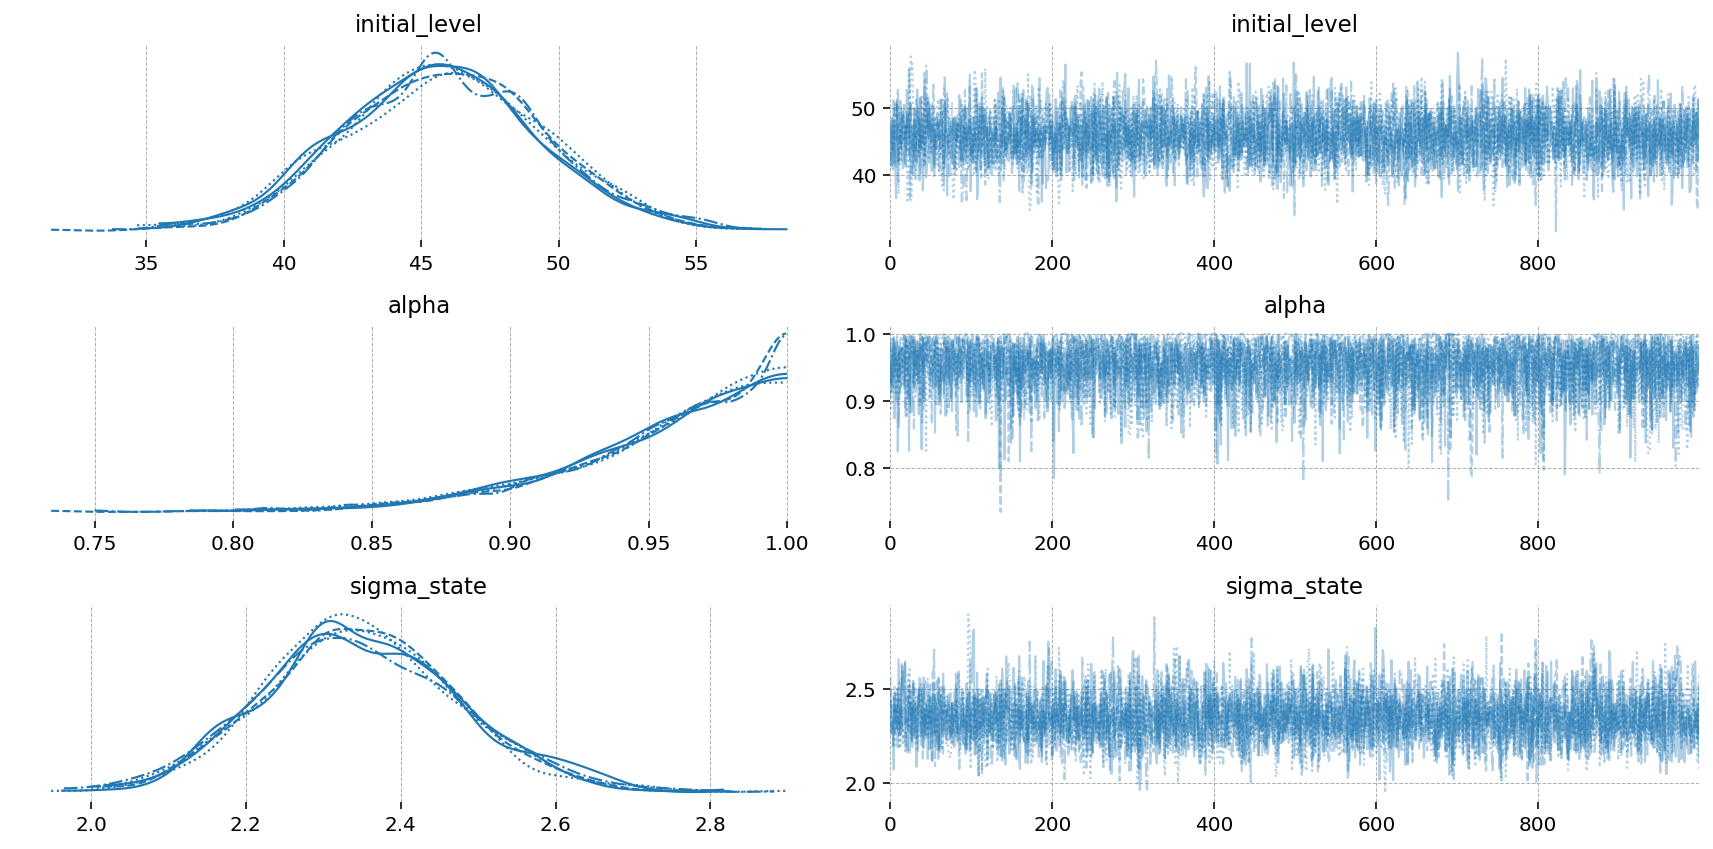

In [16]:
az.plot_trace(idata, var_names=[x.name for x in mod.free_RVs])
plt.tight_layout()

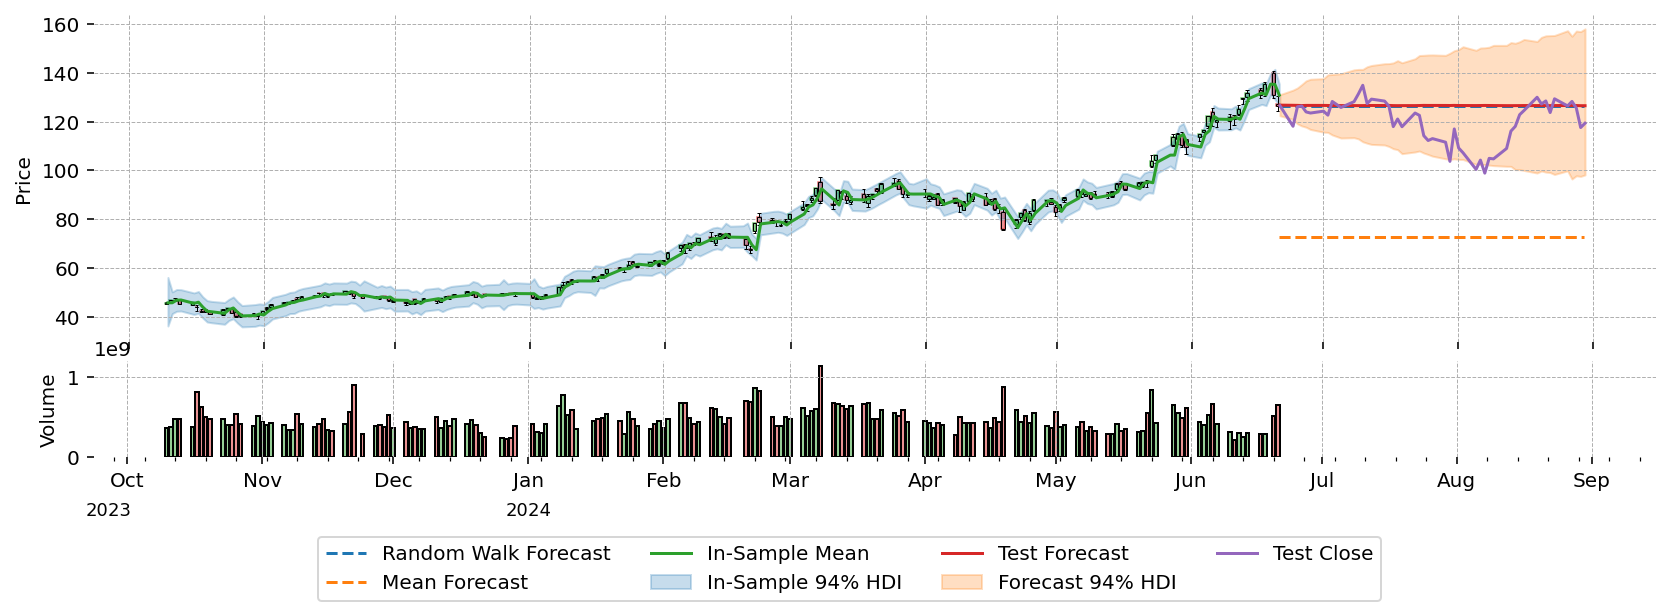

In [17]:
plot_candlesticks_with_forecast(
    df_train, df_test, idata_post, forecast, draw_rw=True, draw_mean=True
);

# Adding a Trend

As alluded to in the presentation of the `order` argument, ETS models can accomodate a trend and seasonal component. For details about how the model develops in those cases, the reader is refered to Forecasting: Principles and Practice, [Chapter 8.2](https://otexts.com/fpp3/holt.html) and [Chapter 8.3](https://otexts.com/fpp3/holt-winters.html), respectively. Here we present just a quick summary.

When we add a trend, we extend the model to estimate a local slope at each timestep. Like the level, the slope is weighted average of:

1. An estimated hidden state, $b_t$, and;
2. The change in the level at time $t$, $\ell_t - \ell_{t-1}$

The hidden state at time $t$ is thus:

$$
b_t = \beta^\star (\ell_t - \ell_{t-1}) + (1 - \beta^\star) b_{t-1}
$$

With $\beta^\star \in (0, 1)$. The $\star$ is used to distinguish between two parameterizations. If you do the same algebraic gymnastics as above, you will find the following statespace:

$$
\begin{align}
y_t&=\ell_{t-1}+b_{t-1}+\varepsilon_t\\
\ell_t&=\ell_{t-1}+b_{t-1}+\alpha \varepsilon_t\\
b_t&=b_{t-1}+ \alpha \beta^\star \varepsilon_t
\end{align}
$$

How the statespace matrices look in this case is left as an exericse to the reader.

Note that the level and trend weights, $\alpha$ and $\beta^\star$, are multiplied together in the trend update equation. This is why an alternative parameterization exists. The `fable` R package, as well as the `statsmodels` trend smoothing implementation, use $\beta = \alpha \beta^\star$. As a result, $\alpha$ is first estimated, then $\beta$ is estimated such that $0 < \beta < \alpha$ (dividing through by $\alpha$ gives $0 < \beta^\star < 1$).

By default, `BayesianETS` gives you the "star" parameterization, so you can set priors for $\beta^\star$ on the unit interval. If you want the other one, you can request `use_transformed_parameterization = True`, but be aware you're responsible for making sure $0 < \beta < \alpha$ is respected.

## Interactive Graph

Playing with this graph, you will find that unlike in a model with a trend *parameter*, like a slope-intercept model, the value of $\beta$ is not obviously connected to the slope of the forecasts. When $\beta$ is large, the forecasts are negative, because a large $\beta$ puts more weight on the most recent level shifts. Since the very end of the data is a downtick, this will render the forecast negative. 

When $\beta$ is very small, on the other hand, the level shifts in the data are given more equal weight. Since the overall trend in the data is positive, this results in a positive slope in the forecast.

In [18]:
# Create ETS model
mod = pmss.BayesianETS(order=("A", "Ad", "N"), verbose=False)
interactive_plot = make_interactive_plot(
    mod, df_train, df_test, include_trend=True, draw_lines=False
)

# Display the widgets
display(interactive_plot)

interactive(children=(FloatSlider(value=0.99, description='Alpha:', max=0.999999, min=1e-06, step=0.01), Float…

## Fit the Model

In [19]:
ss_trend_mod = pmss.BayesianETS(
    order=("A", "A", "N"), stationary_initialization=True, initialization_dampening=0.8
)

The following parameters should be assigned priors inside a PyMC model block: 
	initial_level -- shape: None, constraints: None, dims: None
	initial_trend -- shape: None, constraints: None, dims: None
	alpha -- shape: None, constraints: 0 < alpha < 1, dims: None
	beta -- shape: None, constraints: 0 < beta < 1, dims: None
	sigma_state -- shape: None, constraints: Positive, dims: None


In [20]:
with pm.Model(coords=ss_trend_mod.coords) as trend_mod:
    initial_level = pm.Normal("initial_level", mu=df_train.Close.values[0], sigma=10)
    initial_trend = pm.Normal("initial_trend", mu=0, sigma=3)

    alpha = pm.Beta("alpha", alpha=3, beta=1)
    beta = pm.Beta("beta", alpha=1, beta=1)

    sigma_state = pm.Exponential("sigma_state", lam=1)

    ss_trend_mod.build_statespace_graph(data=df_train.Close, mode="JAX")

ntp_mod = ntp.compile_pymc_model(
    freeze_dims_and_data(trend_mod), backend="jax", gradient_backend="jax"
)

with warnings.catch_warnings(action="ignore"):
    idata_trend = ntp.sample(ntp_mod)
    idata_trend_post = ss_trend_mod.sample_conditional_posterior(idata_trend)
    idata_trend_forecast = ss_trend_mod.forecast(
        idata_trend, start=df_train.index[-1], end=df_test.index[-1]
    )

/Users/jessegrabowski/Documents/Python/pymc-experimental/pymc_experimental/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)


Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

Sampling: [forecast_combined]


Output()

In [21]:
az.summary(idata_trend, var_names=[x.name for x in trend_mod.free_RVs])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
initial_level  45.786  3.785  38.831   52.878      0.047    0.033    6497.0   
initial_trend   0.105  0.610  -1.127    1.197      0.011    0.010    3131.0   
alpha           0.929  0.052   0.835    1.000      0.001    0.001    3607.0   
beta            0.040  0.030   0.000    0.092      0.001    0.000    2641.0   
sigma_state     2.324  0.124   2.088    2.547      0.002    0.001    6284.0   

               ess_tail  r_hat  
initial_level    4367.0    1.0  
initial_trend    1741.0    1.0  
alpha            2201.0    1.0  
beta             2112.0    1.0  
sigma_state      4673.0    1.0

Adding a trend makes the out-of-sample fit much worse. It extrapolates out the trend forever in an extremely optimistic fashion! Note that our estimated beta is quite small -- between 0.0 and 0.08. But it still

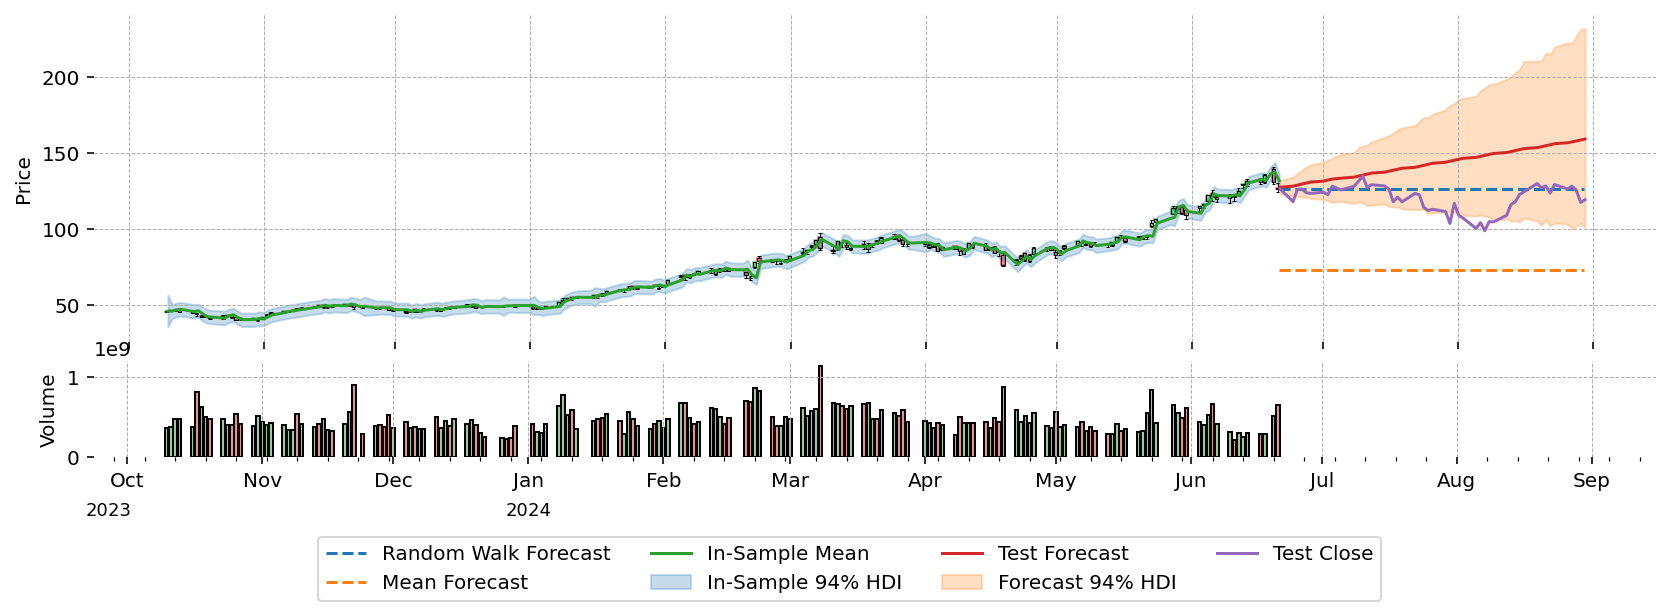

In [22]:
plot_candlesticks_with_forecast(
    df_train, df_test, idata_trend_post, idata_trend_forecast, draw_rw=True, draw_mean=True
);

### Damped Trend

One way to "fix" these overly optimistic trends is to add a dampening term. This will force the trend to slow down over time, making forecasts slowly return to a long-run mean. To ask for a damped trend, use `Ad` order for the trend. 

By the way, if you don't care for this `order` business, you can instead build the model using a series of boolean arguments. This is demonstrated below.

We now need to give a prior for `phi`, which is the degree of dampening on the trend term. [FPP3 gives guidance](https://otexts.com/fpp3/holt.html#damped-trend-methods) on choosing priors for $\phi$:

> In practice, $\phi$ is rarely less than 0.8 as the damping has a very strong effect for smaller values. Values of $\phi$ close to 1 will mean that a damped model is not able to be distinguished from a non-damped model. For these reasons, we usually restrict $\phi$ to a minimum of 0.8 and a maximum of 0.98.

In the interactive graph, try setting $\beta$ to be large and small, and see how varying $\phi$ interacts in both of these regimes. You should find that for large beta, having a dampening term on the trend causes a "bend" back to a long term mean. If beta is too small, however, having even $\phi = 0.99$ essentially erases the trend.

In [23]:
# Use interactive to link sliders with update function
interactive_plot = make_interactive_plot(
    mod=mod,
    df_train=df_train,
    df_test=df_test,
    n_draws=100,
    include_trend=True,
    include_phi=True,
    draw_lines=False,
)
# Display the widgets
display(interactive_plot)

interactive(children=(FloatSlider(value=0.99, description='Alpha:', max=0.999999, min=1e-06, step=0.01), Float…

In [24]:
# Equivalent to order = ("A", "Ad", "N")
ss_mod_damped = pmss.BayesianETS(trend=True, damped_trend=True, stationary_initialization=True)

The following parameters should be assigned priors inside a PyMC model block: 
	initial_level -- shape: None, constraints: None, dims: None
	initial_trend -- shape: None, constraints: None, dims: None
	alpha -- shape: None, constraints: 0 < alpha < 1, dims: None
	beta -- shape: None, constraints: 0 < beta < 1, dims: None
	phi -- shape: None, constraints: 0 < phi < 1, dims: None
	sigma_state -- shape: None, constraints: Positive, dims: None


In [25]:
with pm.Model(coords=ss_mod_damped.coords) as damped_trend_mod:
    initial_level = pm.Normal("initial_level", mu=df_train.Close.values[0], sigma=10)
    initial_trend = pm.Normal("initial_trend", mu=0, sigma=3)

    alpha = pm.Beta("alpha", alpha=3, beta=1)
    beta = pm.Beta("beta", alpha=1, beta=3)

    phi_params = pz.maxent(pz.Beta(), lower=0.8, upper=0.98, plot=False).params_dict
    phi = pm.Beta("phi", **phi_params)

    sigma_state = pm.Exponential("sigma_state", lam=1)

    ss_mod_damped.build_statespace_graph(data=df_train.Close, mode="JAX")

ntp_mod = ntp.compile_pymc_model(
    freeze_dims_and_data(damped_trend_mod), backend="jax", gradient_backend="jax"
)


with warnings.catch_warnings(action="ignore"):
    idata_damped_trend = ntp.sample(ntp_mod, target_accept=0.9)
    idata_damped_post = ss_mod_damped.sample_conditional_posterior(idata_damped_trend)
    idata_damped_forecast = ss_mod_damped.forecast(
        idata_damped_trend, start=df_train.index[-1], end=df_test.index[-1]
    )

/Users/jessegrabowski/Documents/Python/pymc-experimental/pymc_experimental/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)


Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

Sampling: [forecast_combined]


Output()

In [26]:
az.summary(idata_damped_trend, var_names=[x.name for x in damped_trend_mod.free_RVs])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
initial_level  45.901  4.188  38.114   53.807      0.047    0.033    8023.0   
initial_trend  -0.230  1.271  -2.706    2.160      0.015    0.016    6849.0   
alpha           0.922  0.056   0.822    1.000      0.001    0.001    4576.0   
beta            0.074  0.043   0.000    0.148      0.001    0.000    4074.0   
phi             0.896  0.050   0.801    0.976      0.001    0.000    6529.0   
sigma_state     2.338  0.126   2.108    2.581      0.002    0.001    6828.0   

               ess_tail  r_hat  
initial_level    4638.0    1.0  
initial_trend    4458.0    1.0  
alpha            2989.0    1.0  
beta             1989.0    1.0  
phi              3664.0    1.0  
sigma_state      4597.0    1.0

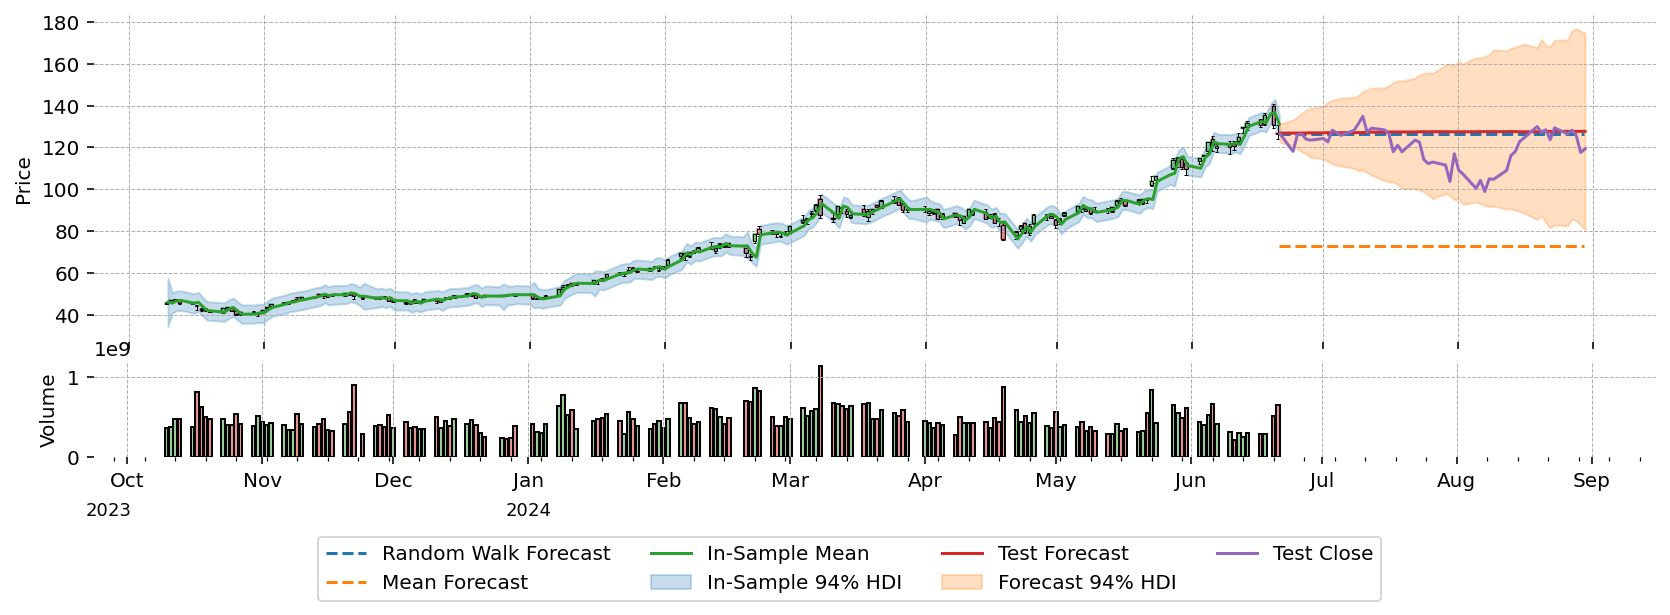

In [27]:
plot_candlesticks_with_forecast(
    df_train, df_test, idata_damped_post, idata_damped_forecast, draw_rw=True, draw_mean=True
);

# Joint Estimation of Correlated Time Series

One feature that `BayesianETS` has that statsmodels does not is support for multiple time series.

By using the `endog_names` argument, you can jointly estimate multiple ETS series at the same time. Currently you are restricted to the same ETS family (as specified by the `order`) for each time series, and each time series will have its own $\alpha, \beta, \gamma, \phi$ parameters -- although these cane be correlated (or even re-used!) by setting priors.

What is nice, though, is that you can estimate a dense covariance for the innovarions on each time series. To do this, we ask for `dense_innovation_covariance=True`. If we set this to `False`, we estimate a diagonal covariance matrix. 

We demonstrate this functionaly by simultaneously estimating the closing price and the trading volume for \$NVDA.

In [28]:
ss_mod_joint = pmss.BayesianETS(
    endog_names=["Close", "Volume"],
    order=("A", "Ad", "N"),
    dense_innovation_covariance=True,
    stationary_initialization=True,
)

The following parameters should be assigned priors inside a PyMC model block: 
	initial_level -- shape: (2,), constraints: None, dims: ('observed_state',)
	initial_trend -- shape: (2,), constraints: None, dims: ('observed_state',)
	alpha -- shape: (2,), constraints: 0 < alpha < 1, dims: ('observed_state',)
	beta -- shape: (2,), constraints: 0 < beta < 1, dims: ('observed_state',)
	phi -- shape: (2,), constraints: 0 < phi < 1, dims: ('observed_state',)
	state_cov -- shape: (2, 2), constraints: Positive Semi-definite, dims: ('observed_state', 'observed_state_aux')


Notice that the required shapes have change. We now need to give `observed_state` to all the structural parameters, implying that we need one for each sub-model (Price and Close).

It's good to check the coords to see how the model expects things passed in:

In [29]:
ss_mod_joint.observed_states

['Close', 'Volume']

In [30]:
ss_mod_joint.state_names

['Close_innovation',
 'Close_level',
 'Close_trend',
 'Volume_innovation',
 'Volume_level',
 'Volume_trend']

In [31]:
# Re-scale volume to be in logs. This is equivalent to specifying a fully multiplicative model, order (M, Md, N)
# MCMC algorithms are never happy to work with huge numbers, so things won't work unless we re-scale somehow
df_scaled = df_train[["Close", "Volume"]].assign(Volume=lambda x: np.log(x.Volume))

In [32]:
with pm.Model(coords=ss_mod_joint.coords) as joint_mod:
    initial_level = pm.Normal("initial_level", mu=0, sigma=10, dims=["observed_state"])
    initial_trend = pm.Normal("initial_trend", mu=0, sigma=10, dims=["observed_state"])

    alpha = pm.Beta("alpha", alpha=3, beta=1, dims=["observed_state"])
    beta = pm.Beta("beta", alpha=1, beta=5, dims=["observed_state"])

    phi_params = pz.maxent(pz.Beta(), lower=0.8, upper=0.98, plot=False).params_dict
    phi = pm.Beta("phi", **phi_params, dims=["observed_state"])

    sd_dist = pm.Gamma.dist(alpha=2, beta=[1, 1 / 10])
    chol, *_ = pm.LKJCholeskyCov("state_chol", eta=1, n=2, sd_dist=sd_dist)
    state_cov = pm.Deterministic(
        "state_cov", chol @ chol.T, dims=["observed_state", "observed_state_aux"]
    )

    ss_mod_joint.build_statespace_graph(data=df_scaled, mode="JAX")

ntp_mod = ntp.compile_pymc_model(
    freeze_dims_and_data(joint_mod), backend="jax", gradient_backend="jax"
)


with warnings.catch_warnings(action="ignore"):
    idata_joint = ntp.sample(ntp_mod)
    idata_joint_post = ss_mod_joint.sample_conditional_posterior(idata_joint)
    idata_joint_forecast = ss_mod_joint.forecast(
        idata_joint, start=df_train.index[-1], end=df_test.index[-1]
    )

/Users/jessegrabowski/Documents/Python/pymc-experimental/pymc_experimental/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
/Users/jessegrabowski/mambaforge/envs/pymc-experimental/lib/python3.12/functools.py:907: UserWarning: Skipping `CheckAndRaise` Op (assertion: PyTensor Assert failed!) as JAX tracing would remove it.
  return dispatch(args[0].__class__)(*args, **kw)


Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

Sampling: [forecast_combined]


Output()

In [33]:
az.summary(
    idata_joint,
    var_names=[
        "initial_level",
        "initial_trend",
        "alpha",
        "beta",
        "phi",
        "state_chol_stds",
        "state_chol_corr",
    ],
    coords={"state_chol_corr_dim_0": [0], "state_chol_corr_dim_1": [1]},
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
initial_level[Close]   36.738  5.326  26.008   45.775      0.100    0.071   
initial_level[Volume]  19.769  0.311  19.204   20.389      0.003    0.002   
initial_trend[Close]   -1.139  1.617  -4.105    1.935      0.028    0.025   
initial_trend[Volume]   0.075  0.115  -0.122    0.313      0.002    0.002   
alpha[Close]            0.931  0.053   0.836    1.000      0.001    0.000   
alpha[Volume]           0.560  0.096   0.389    0.747      0.001    0.001   
beta[Close]             0.087  0.050   0.003    0.177      0.001    0.001   
beta[Volume]            0.025  0.027   0.000    0.070      0.000    0.000   
phi[Close]              0.904  0.050   0.811    0.987      0.001    0.000   
phi[Volume]             0.856  0.063   0.742    0.968      0.001    0.001   
state_chol_stds[0]      2.379  0.131   2.139    2.624      0.001    0.001   
state_chol_stds[1]      0.252  0.014   0.226    0.278      0.000    0.000   
state_chol_corr[0, 1]  -0.082  0.075  -0.226    0.056      0.001    0.001   

                       ess_bulk  ess_tail  r_hat  
initial_level[Close]     3580.0    2226.0    1.0  
initial_level[Volume]    9784.0    4660.0    1.0  
initial_trend[Close]     3778.0    2688.0    1.0  
initial_trend[Volume]    5132.0    3319.0    1.0  
alpha[Close]             4845.0    3082.0    1.0  
alpha[Volume]            7601.0    3855.0    1.0  
beta[Close]              4115.0    2875.0    1.0  
beta[Volume]             6004.0    3550.0    1.0  
phi[Close]               5237.0    3168.0    1.0  
phi[Volume]              4805.0    3194.0    1.0  
state_chol_stds[0]       9485.0    4728.0    1.0  
state_chol_stds[1]       9148.0    4141.0    1.0  
state_chol_corr[0, 1]   10140.0    4201.0    1.0

We find that the innovation structure between these variables are negatively correlated. When the innovations errors on volume are large, the innovations on price are small. 

Note that this is different from saying that the two series are themselves connected. For example, we could imagine a VAR-type scheme where the levels or trends of each time series are a weighted combination of the weighted combinations of all series. We are *not* doing that. Instead, we are just doing the following:

$$
\begin{align}
P_t &= \ell_{P, t-1} + b_{P, t-1} + \varepsilon_{P,t} \\
V_t &= \ell_{V, t-1} + b_{V, t-1} + \varepsilon_{V,t} \\
\begin{bmatrix} \varepsilon_{P, t} \\ \varepsilon_{V,t} \end{bmatrix} &\sim N(0, \Sigma)
\end{align}
$$

<Axes: title={'center': 'state_chol_corr\n0, 1'}>

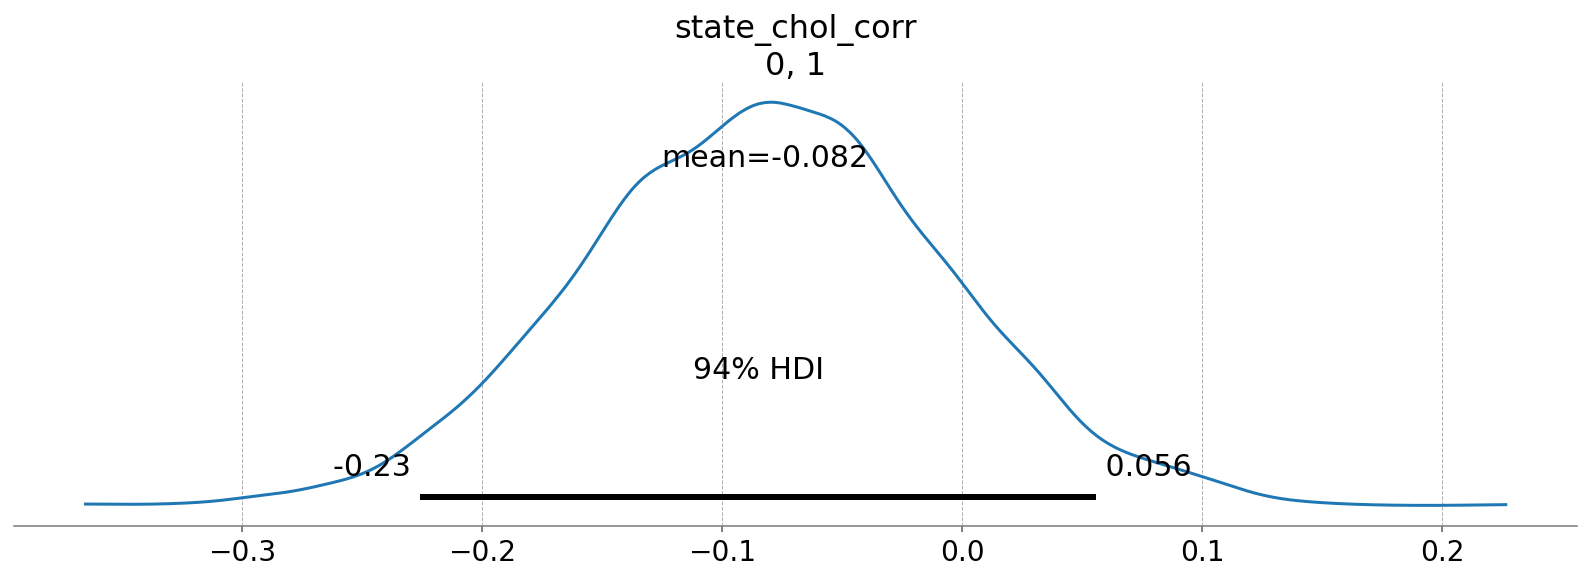

In [34]:
az.plot_posterior(
    idata_joint,
    var_names=["state_chol_corr"],
    coords={"state_chol_corr_dim_0": [0], "state_chol_corr_dim_1": [1]},
)

Next we plot the predictions. Both models chose levels close to the most recent observation, with little or no trend. The volume appears to be bending upwards because of the use of multiplicative errors (we apply `np.exp` to the posterior forecasts samples to get back to the data scale)

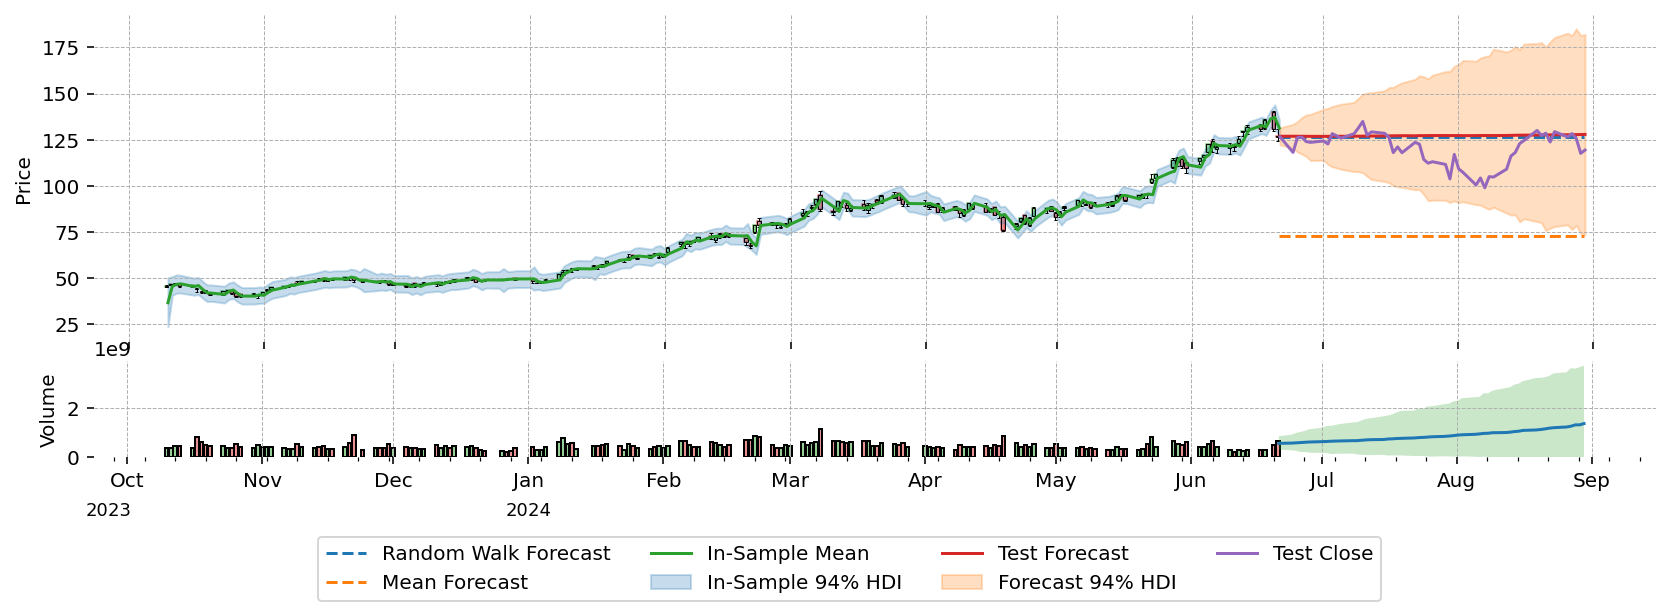

In [35]:
fig = plot_candlesticks_with_forecast(
    df_train, df_test, idata_joint_post, idata_joint_forecast, draw_mean=True, draw_rw=True
)
vol_ax = fig.axes[1]
log_vol_hat = idata_joint_forecast.forecast_observed.sel(observed_state="Volume").isel(
    time=slice(1, None)
)
vol_hat = np.exp(log_vol_hat)

vol_hdi = az.hdi(vol_hat).forecast_observed
vol_ax.plot(df_test.index, vol_hat.mean(dim=["chain", "draw"]))
vol_ax.fill_between(df_test.index, *vol_hdi.values.T, alpha=0.25)

# Bonus: Seasonality

There is no reason to believe that there are seasonal patterns in stock price data. To demonstrate how seasonality works, we turn to a different dataset: the well-studied `airpass.csv`, showing a monthly number of international airline passangers in the US between 1949 and 1960.  

<Axes: xlabel='time'>

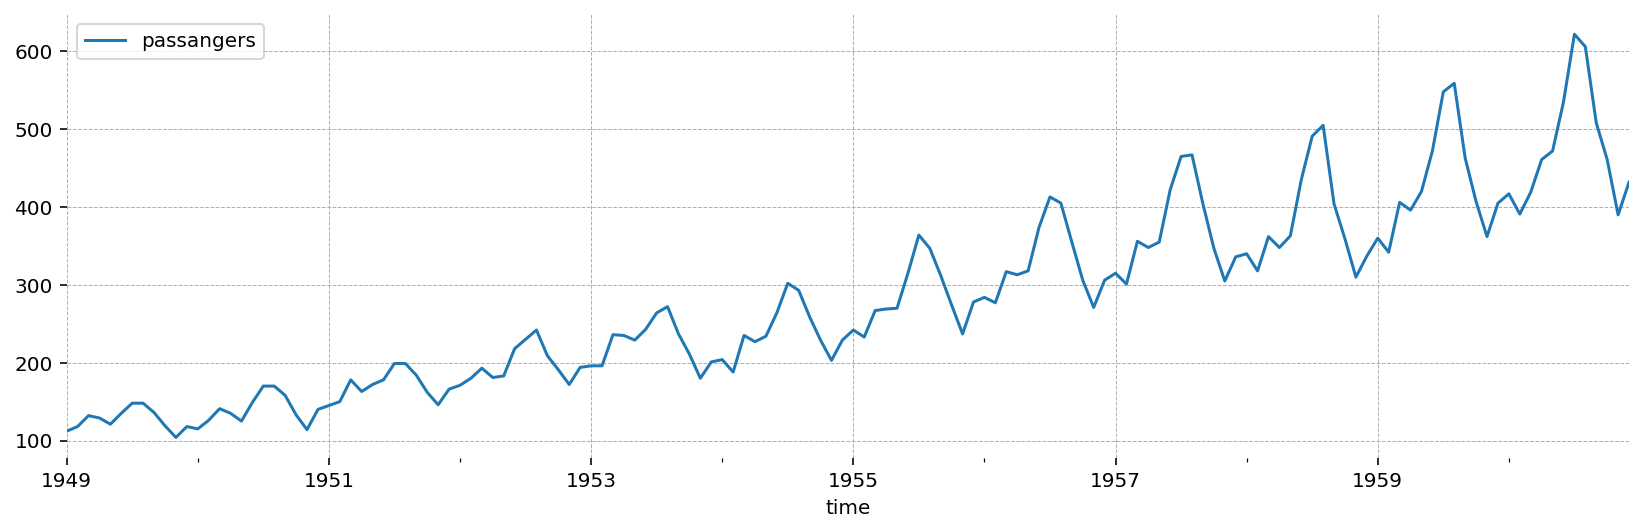

In [36]:
df = (
    pd.read_csv("../tests/statespace/test_data/airpassangers.csv", parse_dates=["Month"])
    .rename(columns={"Month": "time", "#Passengers": "passangers"})
    .set_index("time")
    .astype(float)
)
df.plot()

The data appear to have increasing variance over time, which is the tell-tale sign of multiplicative errors. As a result, we model the log of the data, then exponentiate the outputs.

<Axes: xlabel='time'>

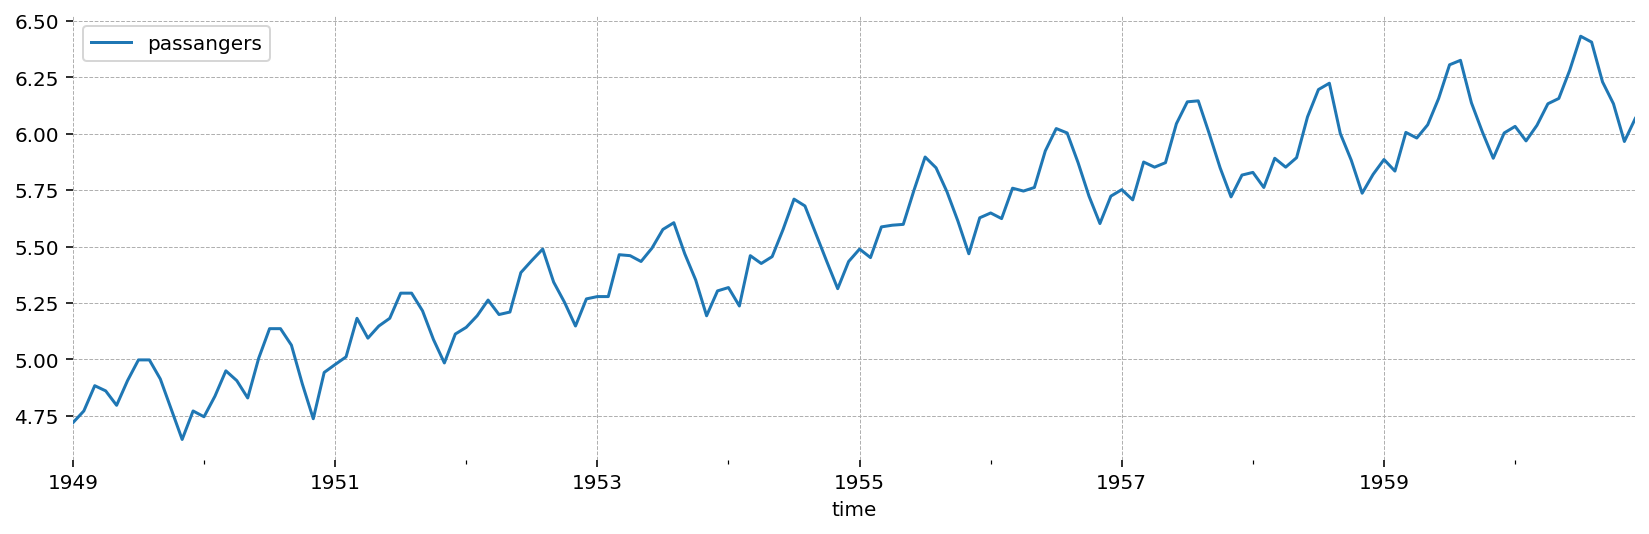

In [37]:
df.map(np.log).plot()

In [38]:
airpass_ss_mod = pmss.BayesianETS(
    endog_names=["Passengers"],
    order=("A", "Ad", "A"),
    seasonal_periods=12,
    stationary_initialization=True,
)

The following parameters should be assigned priors inside a PyMC model block: 
	initial_level -- shape: None, constraints: None, dims: None
	initial_trend -- shape: None, constraints: None, dims: None
	initial_seasonal -- shape: (12,), constraints: None, dims: ('seasonal_lag',)
	alpha -- shape: None, constraints: 0 < alpha < 1, dims: None
	beta -- shape: None, constraints: 0 < beta < 1, dims: None
	gamma -- shape: None, constraints: 0 < gamma< 1, dims: None
	phi -- shape: None, constraints: 0 < phi < 1, dims: None
	sigma_state -- shape: None, constraints: Positive, dims: None


In [39]:
with pm.Model(coords=airpass_ss_mod.coords) as airpass_mod:
    initial_level = pm.Normal("initial_level", mu=0, sigma=3)
    initial_trend = pm.Normal("initial_trend", mu=0, sigma=1)
    initial_seasonal = pm.ZeroSumNormal("initial_seasonal", sigma=1, dims=["seasonal_lag"])

    alpha = pm.Beta("alpha", alpha=1, beta=1)
    beta = pm.Beta("beta", alpha=1, beta=1)
    gamma = pm.Beta("gamma", alpha=1, beta=1)

    phi_params = pz.maxent(pz.Beta(), lower=0.85, upper=0.98, plot=False).params_dict
    phi = pm.Beta("phi", **phi_params)

    sigma_state = pm.Exponential("sigma_state", lam=1)

    airpass_ss_mod.build_statespace_graph(data=df.map(np.log), mode="JAX")


ntp_mod = ntp.compile_pymc_model(
    freeze_dims_and_data(airpass_mod), backend="jax", gradient_backend="jax"
)


with warnings.catch_warnings(action="ignore"):
    idata_airpass = ntp.sample(ntp_mod, target_accept=0.95)
    idata_airpass_post = airpass_ss_mod.sample_conditional_posterior(idata_airpass)
    idata_airpass_forecast = airpass_ss_mod.forecast(
        idata_airpass, start=df.index[-1], end=df.index.shift(36)[-1]
    )

/Users/jessegrabowski/Documents/Python/pymc-experimental/pymc_experimental/statespace/utils/data_tools.py:97: UserWarning: No frequency was specific on the data's DateTimeIndex.
  warnings.warn(NO_FREQ_INFO_WARNING)


Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

Sampling: [forecast_combined]


Output()

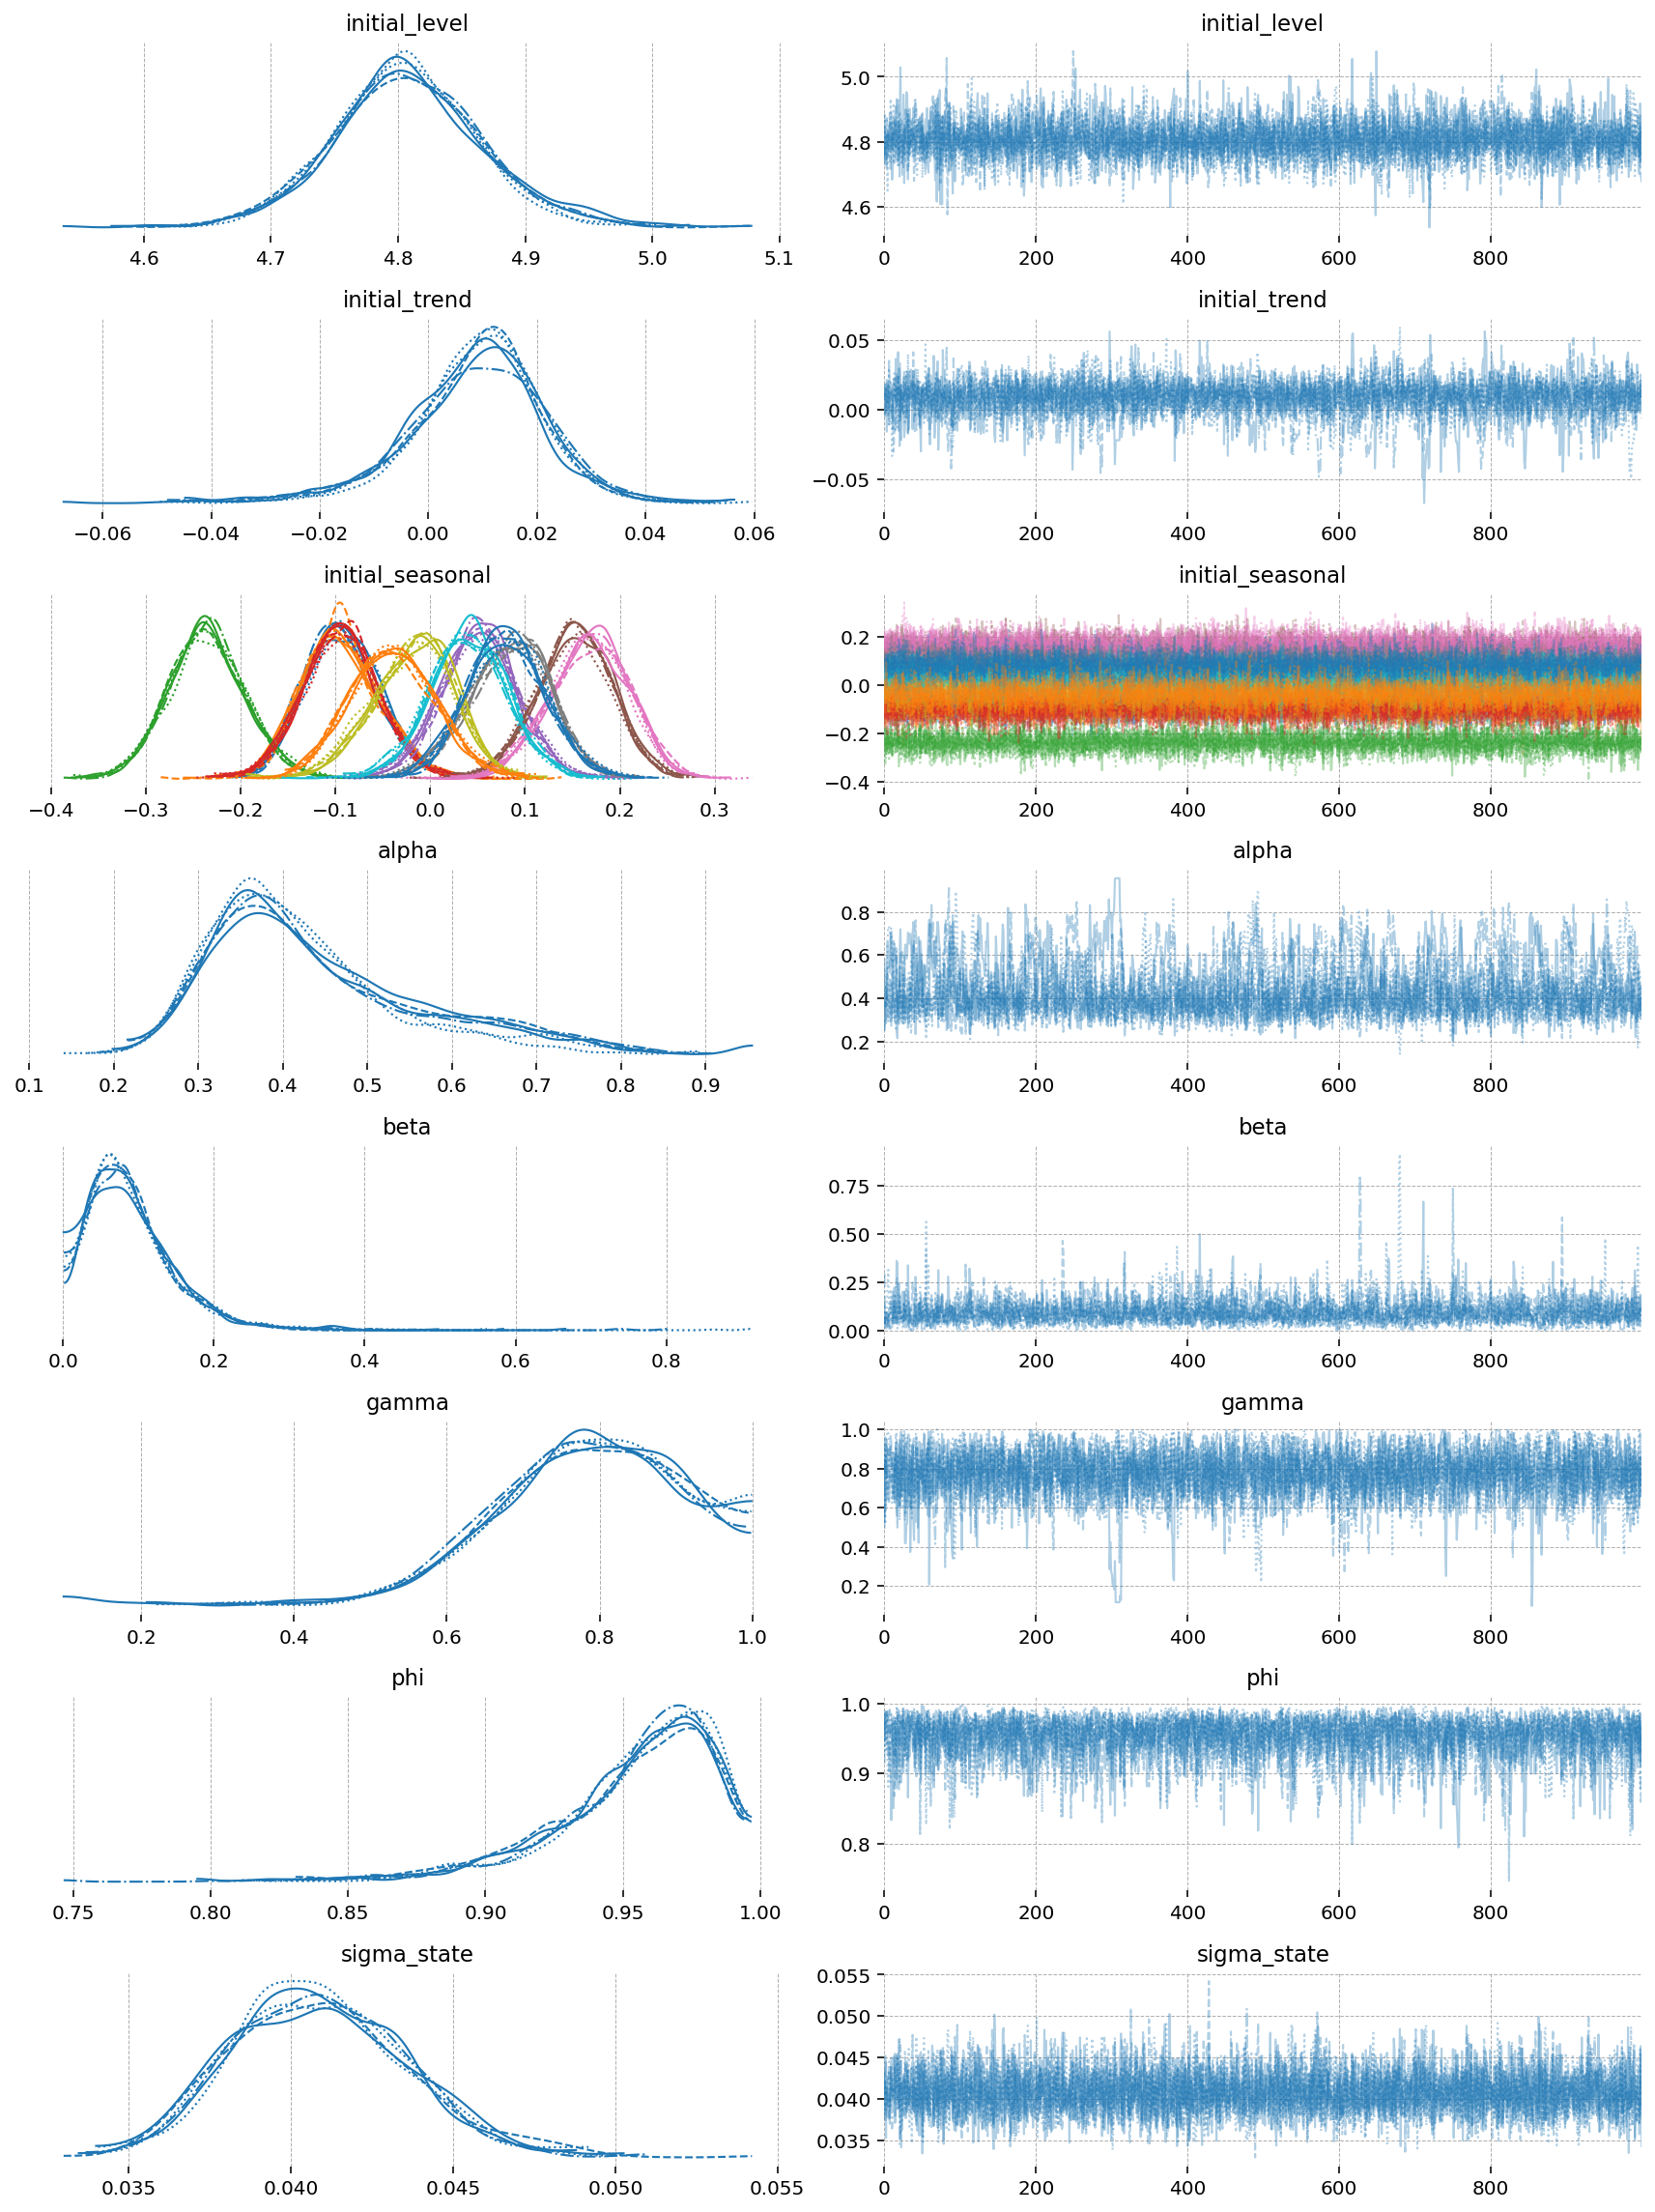

In [40]:
az.plot_trace(idata_airpass, var_names=[x.name for x in airpass_mod.free_RVs])
plt.tight_layout()
plt.show()

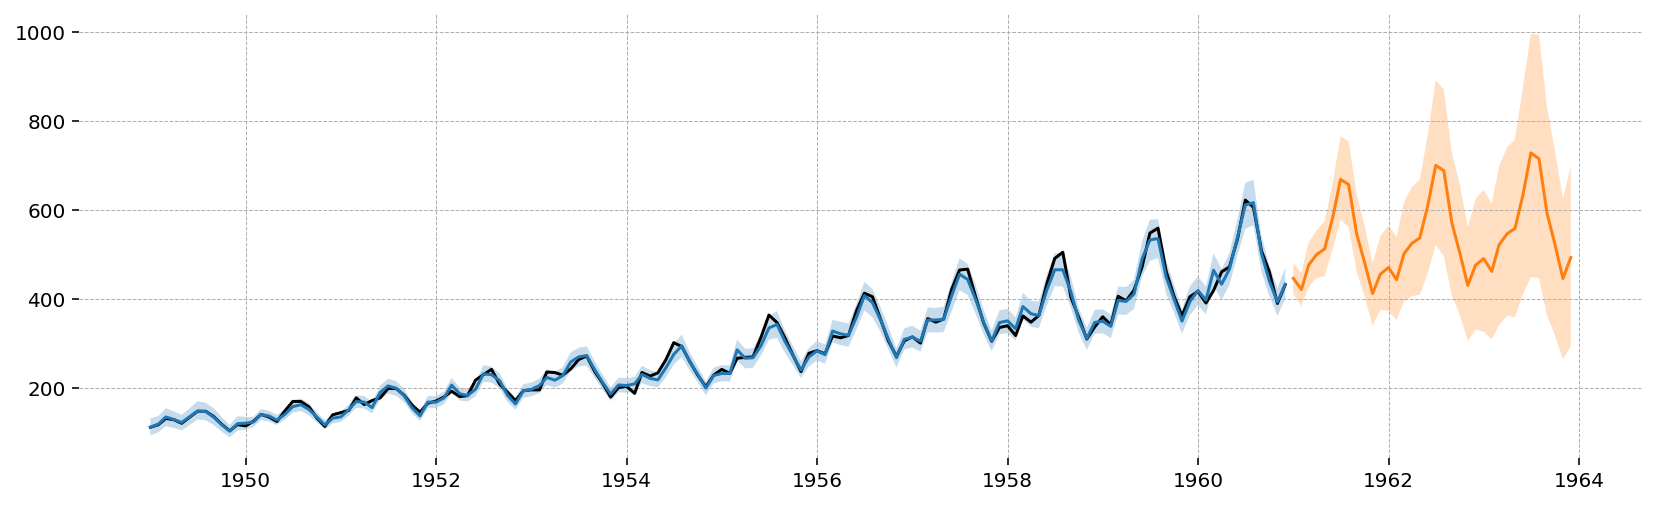

In [41]:
fig, ax = plt.subplots()

idata_post = np.exp(idata_airpass_post.predicted_posterior_observed.isel(observed_state=0))
idata_foreacast = np.exp(idata_airpass_forecast.forecast_observed.isel(observed_state=0))


mu = idata_post.mean(dim=["chain", "draw"])
hdi = az.hdi(idata_post).predicted_posterior_observed

ax.plot(df.index, df.passangers, c="k")
ax.plot(df.index, mu)
ax.fill_between(df.index, *hdi.values.T, alpha=0.25)


mu_forecast = idata_foreacast.mean(dim=["chain", "draw"]).isel(time=slice(1, None))
hdi_forecast = az.hdi(idata_foreacast).forecast_observed.isel(time=slice(1, None))
forecast_idx = df.index.shift(36)[-36:]
ax.plot(forecast_idx, mu_forecast)
ax.fill_between(forecast_idx, *hdi_forecast.values.T, alpha=0.25)

# References

<a name="Brown1959"></a>
**Brown, Robert G.** *Statistical Forecasting for Inventory Control*. McGraw-Hill, 1959.

<a name="Holt1957"></a>
**Holt, Charles C.** "Forecasting Seasonals and Trends by Exponentially Weighted Averages." *ONR Memorandum No. 52*, Carnegie Institute of Technology, 1957. Reprinted in *International Journal of Forecasting*, 2004. https://doi.org/10.1016/j.ijforecast.2003.09.015

<a name="Winters1960"></a>
**Winters, Peter R.** "Forecasting Sales by Exponentially Weighted Moving Averages." *Management Science*, vol. 6, no. 3, 1960, pp. 324–42. https://doi.org/10.1287/mnsc.6.3.324

<a name="ffp3"></a>
**Hyndman, Rob J., and George Athanasopoulos**. "Forecasting: Principles and Practice. 3rd ed.", *OTexts*, 2021, https://otexts.com/fpp3/.